# Predicting Interest Rates for Bank Loans
In this project, I use a dataset of loans from a bank to predict the interest rate an applicant can expect
- first, I wrangle the data by cleansing it of missing values, useless variables, and leaky information
- then, I feature engineer a few columns to hopefully improve my model's performance
- finally, I iterate through various models, optimizing hyperparameters for each, to find the best model
- I obtain a model which can account for 90% of the variance in the data and predict interest rate with a mean
error of 0.9%

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import time

from pandas_profiling import ProfileReport

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Data Wrangling and Feature Engineering
Here, I clean my data into a format that will be a suitable input for modeling. I get rid of columns with high cardinality or a cardinality of 1, excessive NaN values, as well as all the columns containing leaky information. The leaky variables were variables in the dataset available after the loan had been approved - had I not gotten rid of them, my model would have had much greater predictive power (I tested this for myself but running the same analyses without a fully wrangled dataframe - that analysis is not included here) but it would have been a *useless* model since the majority of the predictive power would have come from columns like the 'grade' and 'subgrade' columns describing how likely the bank thought the applicant was to pay back the loan, which is very tightly correlated with the interest rate. The more risky a loan is for the bank, the higher interest they will charge on it.

Although it is not obvious from the code, I found the documentation to this dataset and meticulously examined each column to determine if it should be kept, removed, or changed to a more suitable format. 

I engineer a few features, several of which proved to have strong predictive power.

In [142]:
# my dataframe is quite large, starting at 150 columns and over 100,000 rows. 
# I will do some cleaning and feature engineering, but first I need to see all my columns
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 50)

In [4]:
df = pd.read_csv('/Users/nicholashagemann/Lambda/Datasets/loan_data.csv')
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,109889419.0,NaN,20000.0,20000.0,20000.0,36 months,9.44%,640.10,B,B1,IT Support,10+ years,MORTGAGE,99500.0,Source Verified,May-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,296xx,SC,17.19,0.0,Feb-2005,690.0,694.0,0.0,NaN,NaN,15.0,0.0,12835.0,41%,28.0,w,0.0,0.0,21657.670000,21657.67,20000.0,1657.67,0.0,0.0,0.0,Jun-2018,1002.69,NaN,Jul-2018,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,1185.0,159516.0,2.0,3.0,0.0,2.0,16.0,59354.0,70.0,2.0,2.0,4810.0,57.0,...,2.0,0.0,1.0,4.0,10634.0,15465.0,45.4,0.0,0.0,147.0,115.0,3.0,3.0,4.0,3.0,NaN,7.0,NaN,0.0,4.0,4.0,7.0,9.0,8.0,11.0,16.0,4.0,15.0,0.0,0.0,0.0,2.0,100.0,28.6,0.0,0.0,206029.0,72189.0,28300.0,84078.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,68579794.0,NaN,21600.0,21600.0,21600.0,36 months,9.80%,694.95,B,B3,Engineer Tech,10+ years,MORTGAGE,79000.0,Verified,Jan-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,219xx,MD,18.94,1.0,Jun-1995,680.0,684.0,0.0,12.0,NaN,13.0,0.0,17498.0,88.4%,16.0,w,0.0,0.0,24983.207947,24983.21,21600.0,3383.21,0.0,0.0,0.0,Nov-2018,8.94,NaN,May-2019,709.0,705.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,291267.0,0.0,2.0,2.0,2.0,7.0,33987.0,88.0,0.0,0.0,4746.0,88.0,...,0.0,0.0,0.0,2.0,22405.0,897.0,91.1,0.0,0.0,101.0,247.0,27.0,7.0,4.0,27.0,12.0,NaN,12.0,0.0,3.0,7.0,4.0,4.0,4.0,8.0,8.0,7.0,13.0,0.0,0.0,0.0,2.0,93.7,75.0,0.0,0.0,337728.0,51485.0,10100.0,38591.0,NaN,NaN,NaN,NaN

Note: The following code block is the final result of much time and computing power spent analyzing the dataframe - I have removed the code it took to create the wrangle function as its length would only serve to clutter my notebook.

In [6]:
# each row in the data is a specific loan that was issued by a bank
# I choose the issue date of the loan to be the index
df = pd.read_csv('/Users/nicholashagemann/Lambda/Datasets/loan_data.csv', 
                 parse_dates = ['issue_d', 'earliest_cr_line'], 
                 index_col = 'issue_d').sort_values('issue_d')

# we will need to wrangle this data quite a bit before it's suitable for predicting interest rate
def wrangle(df):
    # Begin Data Cleaning
    
    # first I get rid of all columns with more than 20% NaN values
    # note that the necessary columns will be dropped at the same time at the end of wrangle()
    nan_cols = []
    for col in df.columns:
        if df[col].isna().sum()/len(df) > 0.2:
            nan_cols.append(col)

    # each of the following columns had data that was only available after the loan had been approved
    # we want to predict the interest rate for a loan before the bank decides to approve the loan
    # thus, these columns contain leakage and should be dropped
    leaky_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'sub_grade',
                  'total_rec_int', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries',
                  'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'initial_list_status',
                  'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med',
                  'funded_amnt', 'funded_amnt_inv', 'debt_settlement_flag', 'grade', 'loan_status']

    # the following columns did not contain any useful data or were duplicates of other columns
    cols_to_drop = ['title', 'zip_code', 'addr_state', 'fico_range_low',
                    'Unnamed: 0', 'emp_title', 'url', 'id', 'last_credit_pull_d',
                    'earliest_cr_line']
    
    # if a column only has one value it has no predictive power
    for col in df.columns:
        if df[col].nunique() == 1:
            cols_to_drop.append(col)

    # Begin Feature Engineering

    # first I create a feature which identifies how old the borrower's credit is in days
    df['credit_age'] = df.index - df['earliest_cr_line']
    df['credit_age'].astype('timedelta64[D]').astype(int)
    df['credit_age'] = df['credit_age'].dt.days.astype(int)

    # we want our interest rate to be a float, not a string
    # do the same for the amount of credit the borrower is using
    df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)
    df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)

    # we want to represent length of the loan as an integer
    df.loc[df['term'] == ' 36 months', 'term'] = 36
    df.loc[df['term'] == ' 60 months', 'term'] = 60
    df['term'] = df['term'].astype(int)

    # we want to represent employment length as an integer
    df.loc[df['emp_length'] == '< 1 year', 'emp_length'] = 0
    df['emp_length'] = df['emp_length'].str.replace(' ', '').str.replace('year', '').str.replace('s', '').str.replace('+', '')
    df['emp_length'] = pd.to_numeric(df['emp_length'], downcast = 'integer', errors = 'ignore')

    # we want to represent whether the application was individual or joint as binary
    df.loc[df['application_type'] == 'Individual', 'application_type'] = 1
    df.loc[df['application_type'] == 'Joint App', 'application_type'] = 0
    df['application_type'] = df['application_type'].astype(int)

    # drop columns from the data cleaning
    df.drop(columns = nan_cols + leaky_cols + cols_to_drop, inplace = True)

    return df

df = wrangle(df)

In [7]:
# check how many unique values we have for each of our object columns
# looks like it's small enough to use OneHotEncoder
df.select_dtypes('object').nunique()

home_ownership          6
verification_status     3
purpose                14
dtype: int64

In [8]:
# check shape and head of dataframe
print('Shape is: ', df.shape)
df.head()

Shape is:  (128334, 59)


,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_age
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-01,3500.0,36,10.28,113.39,NaN,RENT,20000.0,Not Verified,moving,1.50,0.0,684.0,0.0,17.0,0.0,1882.0,32.4,18.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1399
2007-07-01,5000.0,36,7.43,155.38,7.0,MORTGAGE,95000.0,Not Verified,vacation,3.83,0.0,774.0,0.0,8.0,0.0,3660.0,6.8,16.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2556
2007-07-01,5000.0,36,7.43,155.38,8.0,MORTGAGE,150000.0,Not Verified,home_improvement,0.00,0.0,779.0,0.0,2.0,0.0,6053.0,19.5,19.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7152
2007-07-01,3000.0,36,10.28,97.20,2.0,MORTGAGE,200000.0,Not Verified,home_improvement,0.00,1.0,679.0,0.0,5.0,0.0,0.0,0.0,8.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3802
2007-08-01,4000.0,36,7.75,124.89,1.0,OWN,61800.0,Not Verified,other,3.46,0.0,749.0,0.0,12.0,0.0,1918.0,17.1,16.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2525


In [156]:
df.describe()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_age
count,128334.000000,128334.000000,128334.000000,128334.000000,110332.000000,1.283340e+05,128283.000000,128334.000000,128334.000000,128334.000000,128334.000000,128334.000000,128334.000000,128251.000000,128334.000000,128334.000000,128334.000000,1.222600e+05,1.222600e+05,1.222600e+05,124049.000000,122259.000000,122813.000000,122748.000000,128328.000000,128334.000000,118606.000000,122260.000000,122260.000000,122260.000000,124049.000000,122889.000000,111181.000000,122260.000000,122260.000000,122260.000000,123290.000000,122260.000000,122260.000000,122260.000000,122260.000000,122260.000000,123290.000000,117490.000000,122260.000000,122260.000000,122260.000000,122249.000000,122777.000000,128270.000000,128330.000000,1.222600e+05,1.240490e+05,1.240490e+05,1.222600e+05,128334.000000
mean,14086.224227,40.738510,12.197903,427.166154,6.515336,7.701800e+04,17.992837,0.311702,702.102561,0.606457,11.566981,0.212126,16170.668755,50.735259,24.911676,0.978556,0.004761,3.046517e+02,1.425918e+05,3.346212e+04,4.566502,13672.122380,10808.781351,58.705261,0.008993,15.151978,126.718851,183.661917,13.440733,8.060420,1.674492,24.339127,6.948274,0.511369,3.633527,5.591076,4.749882,8.103869,8.514297,8.259038,14.583748,5.541027,11.610609,0.000775,0.003321,0.087428,2.096221,94.150099,43.522208,0.132743,0.051742,1.769755e+05,4.945455e+04,2.230894e+04,4.213447e+04,6006.686077
std,8614.852963,9.553611,3.703500,257.585471,3.357604,7.953183e+04,10.661602,0.870466,32.595891,0.897196,5.453600,0.614769,21340.637088,24.440515,11.901112,0.144860,0.072904,2.627026e+04,1.586927e+05,3.318267e+04,3.114648,16549.896057,15937.004094,28.261167,0.106211,798.333509,52.265588,95.398123,16.539138,8.765441,1.998014,31.466584,5.907532,1.351877,2.231473,3.259552,2.949345,4.779161,7.305871,4.533252,8.066640,3.176103,5.468192,0.029310,0.060171,0.495908,1.788898,8.829109,35.850810,0.373823,0.426985,1.795068e+05,4.746393e+04,2.227299e+04,4.389137e+04,2776.741935
min,500.000000,36.000000,5.310000,14.770000,1.000000,0.000000e+00,0.000000,0.000000,664.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,16.700000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1096.000000
25%,7500.000000,36.000000,9.170000,240.920000,3.000000,4.600000e+04,11.570000,0.000000,679.000000,0.000000,8.000000,0.000000,5935.000000,32.300000,16.000000,1.000000,0.000000,0.000000e+00,2.919900e+04,1.430000e+04,2.000000,3097.500000,1630.000000,36.900000,0.000000,0.000000,99.000000,119.000000,4.000000,3.000000,0.000000,6.000000,2.000000,0.000000,2.000000,3.000000,3.000000,5.000000,3.000000,5.000000,9.000000,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000,91.300000,0.000000,0.000000,0.000000,5.011500e+04,2.050700e+04,8.000000e+03,1.450700e+04,4139.000000
50%,12000.000000,36.000000,12.120000,363.970000,7.000000,6.500000e+04,17.310000,0.000000,694.000000,0.000000,11.000000,0.000000,11081.00

# Creating Training and Validation Data
Here, I create the X (predictor) and y (target) matrices which will then be split into training and testing sets for my models.

In [9]:
# we want to have ~80% of our data for training and ~20% for validation
# we see that the 80th percentile is December 2016
# we have a very large dataset, so we choose to start in January 2017
display(df.iloc[0:1], df.iloc[round(df.shape[0]*0.8):round(df.shape[0]*0.8)+1])

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_age
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-01,3500.0,36,10.28,113.39,NaN,RENT,20000.0,Not Verified,moving,1.5,0.0,684.0,0.0,17.0,0.0,1882.0,32.4,18.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1399


,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_age
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-01,4200.0,36,11.49,138.48,3.0,RENT,44000.0,Not Verified,debt_consolidation,9.08,0.0,669.0,2.0,10.0,1.0,2139.0,22.3,34.0,1,0.0,0.0,5496.0,9600.0,8.0,611.0,5051.0,27.8,0.0,0.0,165.0,169.0,5.0,5.0,0.0,17.0,5.0,0.0,2.0,5.0,2.0,14.0,4.0,7.0,27.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,16095.0,5496.0,7000.0,6495.0,5144


In [10]:
# our prediction target is the interest rate, our predictive matrix will be everything except the target
target = 'int_rate'
y = df[target]
X = df.drop(columns = target)

In [11]:
# separate our training and validation data by our cutoff of January 2017
cutoff = '2017-01-01'
mask = X.index < cutoff
X_train, y_train = X[mask], y[mask]
X_val, y_val = X[~mask], y[~mask]

# check shapes to make sure dimensions are correct
print(f'The shape of the training data is {X_train.shape} for X and {y_train.shape} for y.')
print(f'The shape of the validation data is {X_val.shape} for X and {y_val.shape} for y.')

# make sure no data was lost in the splice
assert len(X_train) + len(X_val) == len(X)

The shape of the training data is (103649, 58) for X and (103649,) for y.
The shape of the validation data is (24685, 58) for X and (24685,) for y.


In [12]:
# our baseline mean absolute error will be the mean interest rate
# baseline R^2 score will of course be 0 or approximately 0
baseline_reg = [y_train.mean()]*len(y_val)
print('Baseline MAE:', mean_absolute_error(y_val, baseline_reg))
print('Baseline R2:', r2_score(y_val, baseline_reg))

Baseline MAE: 3.360100268400727
Baseline R2: -0.009930713374478373


# Best Model - XGBoost 
For the sake of the reader's time, I include my final model here so that it is not necessary to scroll through the various models and tuning of hyperparameters.

My final model predicts interest rate with a mean error below 0.9% and a cross-validated R^2 of 0.91.

In [135]:
%%time
model_final = make_pipeline(OneHotEncoder(use_cat_names = True),
                           StandardScaler(),
                           SimpleImputer(strategy='mean'),
                           XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        reg_alpha = 0,
                                        reg_lambda = 1,
                                        gamma = 0))
model_final.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train, model_final.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_final.predict(X_val)))
print('Validation R2:', model_boost.score(X_val, y_val))

Training MAE: 0.34496464560571966
Validation MAE: 0.8994065691179319
Validation R2: 0.9022665324154702
CPU times: user 2min 55s, sys: 2.1 s, total: 2min 58s
Wall time: 26.3 s


In [157]:
cross_vals = cross_val_score(model_final, X, y)
print(f'Scores: {cross_vals}\nMean: {np.mean(cross_vals)}')

Scores: [0.87971062 0.92950602 0.91982579 0.93255404 0.90019554]
Mean: 0.9123584023146762


# On Optimizing Hyperparameters
For each model, I will optimize whatever hyperparameters are available for that model.

In testing the hyperparameters, I will look at the Mean Absolute Error and R^2 (what percentage of the variance in the data my model accounts for) for the training and validation data, as well as the time it took - the time is necessary since when testing each hyperparameter I do not necessarily want the previously tested hyperparameters to be optimal since the model may take too much time.

By having the MAE, R^2, and Time for each hyperparameter I can know which hyperparameter I will use in my final model while also learning which hyperparameter will be suitable for tuning other hyperparameters - i.e. for my final model I will use the hyperparameter with the lowest MAE and highest R^2, but when tuning the other hyperparameters I will use a value which has a MAE and R^2 *similar* to the best but not as time-expensive.

I choose not to use a GridSearch for the hyperparameters since I am attempting to optimize every hyperparameter and the exponential increase in the time it would take to train my model is not worth the small amount of additional certainty I would gain from knowing I've found the absolute best combination - also, I am sure from past experience with exactly this problem that the increase in accuracy from a GridSearch would be very small compared to the overall increase in accuracy gained through my method (which itself is still small compared to the accuracy of the model itself). 

In going through each model, I also choose the order in which I optimize hyperparameters very deliberately. I start with hyperparameters that will have the greatest effect on the accuracy and then move to hyperparameters with smaller effects - in essence, ordering them so that the later hyperparameters do not affect the earlier hyperparameters. 

# Decision Tree Regressor
Here, I will test the decision tree model and optimize hyperparameters. It is very unlikely that a decision tree will be the best model, as we naturally expect any random forest to outcompete a single tree.

We find, after optimizing hyperparameters, the MAE is 2.28% and the R^2 is 0.4

The only significant hyperparameter to optimize for a decision tree is the depth of the tree - since we have a large dataset, we can rely on the algorithm and not have to choose the minimum samples for a split or a leaf, the maximum features or leaves, or the minimum decrease in impurity. 

We see the depth of the tree significantly affects the accuracy and R^2 but the split criteria does not, and also that it is wise to stick with the default "best" splitter and not the "random" splitter.

In [27]:
# do a broad search first then a narrow search next to save time
depths = [1] + [i for i in range(4, 21, 4)]
train_acc_dt = []
val_acc_dt = []
train_r2_dt = []
val_r2_dt = []
times = []

# for each depth, train the model on the training data then add the accuracies, r^2, and time
for depth in depths:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         DecisionTreeRegressor(random_state = 42,
                                               max_depth = depth))
    model.fit(X_train, y_train)
    train_acc_dt.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_dt.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_dt.append(model.score(X_train, y_train))
    val_r2_dt.append(model.score(X_val, y_val))
    times.append(time.time() - start)

# display stored values to determine best parameter
pd.DataFrame(list(zip(train_acc_dt, val_acc_dt, train_r2_dt, val_r2_dt, times)), index = depths,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
1,2.748390,3.051541,0.135211,0.141579,2.677304
4,2.383164,2.682336,0.323038,0.293088,3.093533
8,2.073969,2.448617,0.458468,0.372393,4.335521
12,1.666364,2.278611,0.608790,0.404045,5.271933
16,1.094386,2.309931,0.784048,0.347419,5.716791
20,0.522953,2.410450,0.916193,0.284530,6.458872


In [29]:
# time for the narrow search
depths = range(8, 17)
train_acc_dt = []
val_acc_dt = []
train_r2_dt = []
val_r2_dt = []
times = []

# for each depth, train the model on the training data then add the accuracies, r^2, and time
for depth in depths:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         DecisionTreeRegressor(random_state = 42,
                                               max_depth = depth))

    model.fit(X_train, y_train)

    train_acc_dt.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_dt.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_dt.append(model.score(X_train, y_train))
    val_r2_dt.append(model.score(X_val, y_val))
    times.append(time.time() - start)

# display stored values to determine best parameter
pd.DataFrame(list(zip(train_acc_dt, val_acc_dt, train_r2_dt, val_r2_dt, times)), index = depths,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
8,2.073969,2.448617,0.458468,0.372393,4.554083
9,1.980117,2.392809,0.492881,0.385546,4.591072
10,1.890626,2.340187,0.528735,0.399359,4.740514
11,1.781031,2.299303,0.567806,0.405387,4.927080
12,1.666364,2.278611,0.608790,0.404045,5.348295
13,1.535595,2.272576,0.652739,0.395549,5.567626
14,1.396054,2.269537,0.697081,0.385290,5.706276
15,1.246817,2.278888,0.741497,0.370015,5.826049
16,1.094386,2.309931,0.784048,0.347419,6.126301


In [31]:
# Here we decide if we should be using MSE or Friedman_MSE to split the cells in the tree - I ignore MAE
# and reducing poisson deviance because the models take significantly longer to train than the MSE variants
# and in attempting the model, my kernel crashes and must be restarted from the beginning :(
criteria = ["mse", "friedman_mse"]
train_acc_dt = []
val_acc_dt = []
train_r2_dt = []
val_r2_dt = []

for crit in criteria:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         DecisionTreeRegressor(random_state = 42,
                                               criterion = crit,
                                               max_depth = 12))

    model.fit(X_train, y_train)

    train_acc_dt.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_dt.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_dt.append(model.score(X_train, y_train))
    val_r2_dt.append(model.score(X_val, y_val))

pd.DataFrame(list(zip(train_acc_dt, val_acc_dt, train_r2_dt, val_r2_dt)), index = criteria,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2
mse,1.666364,2.278611,0.60879,0.404045
friedman_mse,1.666365,2.282730,0.60879,0.402308


In [32]:
# was curious how the 'random' splitter would compare to the 'best' - as expected, 'best' is much better
splits = ['best', 'random']
train_acc_dt = []
val_acc_dt = []
train_r2_dt = []
val_r2_dt = []
times = []

for split in splits:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         DecisionTreeRegressor(random_state = 42,
                                               splitter = split,
                                               max_depth = 12))
    
    model.fit(X_train, y_train)

    train_acc_dt.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_dt.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_dt.append(model.score(X_train, y_train))
    val_r2_dt.append(model.score(X_val, y_val))
    times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_dt, val_acc_dt, train_r2_dt, val_r2_dt, times)), index = splits,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
best,1.666364,2.278611,0.608790,0.404045,5.090214
random,1.998140,2.571510,0.497666,0.317036,3.094958


In [33]:
# make our decision tree model here
model_dt = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        DecisionTreeRegressor(random_state = 42,
                                              max_depth = 12))

In [138]:
%%time
model_dt.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train, model_dt.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_dt.predict(X_val)))
print('Validation R2:', model_dt.score(X_val,y_val))

# our MAE isn't bad for a weak model, but we can do better. R^2 is very low. 

Training MAE: 1.6663641214606018
Validation MAE: 2.2786111301924628
Validation R2: 0.40404549101067366
CPU times: user 4.29 s, sys: 563 ms, total: 4.86 s
Wall time: 4.9 s


<AxesSubplot:title={'center':'Most Important Features'}>

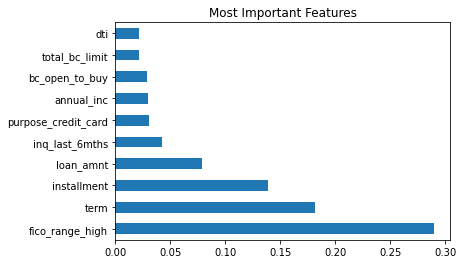

In [35]:
# here I graph the most important features in our model

importances = model_dt.named_steps['decisiontreeregressor'].feature_importances_
features = model_dt.named_steps['onehotencoder'].get_feature_names()
feat_imp_dt = pd.Series(importances, index = features,
                       name = 'tree').abs().sort_values(ascending=False)
feat_imp_dt.head(10).plot(kind = 'barh', title = 'Most Important Features')

# Making Tuning Dataset
For the random forest model, my kernel kept crashing when optimizing hyperparameters by using the full dataset so I decide to tune the hyperparameters using a 'tuning' dataset which is 1/10 of the original dataset

In [41]:
# make tune data which is 1/10 of the train data
X_tune_train = X_train[:len(X_train)//10]
y_tune_train = y_train[:len(y_train)//10]
X_tune_val = X_val[:len(X_val)//10]
y_tune_val = y_val[:len(y_val)//10]

# check to make sure our tuning datasets are indeed 1/10 of our previous training sets
print(f'{X_tune_train.shape}, {X_train.shape}\n{y_tune_train.shape}, {y_train.shape}')
print(f'{X_tune_val.shape}, {X_val.shape}\n{y_tune_val.shape}, {y_val.shape}')

(10364, 58), (103649, 58)
(10364,), (103649,)
(2468, 58), (24685, 58)
(2468,), (24685,)


# Random Forest Regressor

In [49]:
# first hyperparameter to optimize in a random forest is the number of trees
# obviously more trees will only increase the accuracy so we will instead examine when the accuracy approaches
# an asymptote - we will also learn how many estimators we should use for further tuning of hyperparameters, as
# we want enough so that the accuracy is similar to the best accuracy but also not too many for time constraints

estimators = range(10, 201, 10)
train_acc_rf = []
val_acc_rf = []
train_r2_rf = []
val_r2_rf = []
seconds = []

# we will use the previously determined max_depth hyperparameter
for estimator in estimators:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestRegressor(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = 12,
                                              n_estimators = estimator))
    
    model.fit(X_tune_train, y_tune_train)
    
    train_acc_rf.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_rf.append(mean_absolute_error(y_train, model.predict(X_train)))
    train_r2_rf.append(model.score(X_train, y_train))
    val_r2_rf.append(model.score(X_val, y_val))
    seconds.append(time.time() - start)
    
pd.DataFrame(list(zip(train_acc_rf, val_acc_rf, train_r2_rf, val_r2_rf, seconds)), index = estimators,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
10,2.582209,2.582209,0.162645,0.272276,2.562769
20,2.568814,2.568814,0.172051,0.281843,2.642525
30,2.558297,2.558297,0.178843,0.286912,3.085897
40,2.555101,2.555101,0.180604,0.288999,3.324303
50,2.552860,2.552860,0.181744,0.290177,3.737888
60,2.551130,2.551130,0.182773,0.290471,3.885266
70,2.551694,2.551694,0.182401,0.290341,4.080793
80,2.550523,2.550523,0.183231,0.291159,4.518644
90,2.549250,2.549250,0.184042,0.292293,4.649842
100,2.549190,2.549190,0.184153,0.292381,4.871429


In [48]:
# determine what percentage of the data to sample for each decision tree
samples = np.arange(0.05, 1, 0.05)
train_acc_rf = []
val_acc_rf = []
train_r2_rf = []
val_r2_rf = []
seconds = []

for sample in samples:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestRegressor(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = 12,
                                              n_estimators = 30,
                                              max_samples = sample))
    model.fit(X_tune_train, y_tune_train)
    
    train_acc_rf.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_rf.append(mean_absolute_error(y_train, model.predict(X_train)))
    train_r2_rf.append(model.score(X_train, y_train))
    val_r2_rf.append(model.score(X_val, y_val))
    seconds.append(time.time() - start)
    
pd.DataFrame(list(zip(train_acc_rf, val_acc_rf, train_r2_rf, val_r2_rf, seconds)), index = samples,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
0.05,2.615812,2.615812,0.170885,0.310412,2.443685
0.10,2.609338,2.609338,0.170314,0.306717,2.332825
0.15,2.591294,2.591294,0.178513,0.311663,2.335235
0.20,2.580971,2.580971,0.183085,0.313654,2.477202
0.25,2.587098,2.587098,0.175954,0.304289,2.497575
0.30,2.570444,2.570444,0.183020,0.306227,2.570322
0.35,2.572279,2.572279,0.179418,0.304073,2.622693
0.40,2.556248,2.556248,0.187857,0.306602,2.522264
0.45,2.565814,2.565814,0.182614,0.301132,2.790190
0.50,2.565180,2.565180,0.181938,0.302706,3.524909


In [50]:
model_rf = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestRegressor(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = 12,
                                              n_estimators = 180,
                                              max_samples = 0.4))

In [55]:
%%time
model_rf.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train, model_rf.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_rf.predict(X_val)))
print('Validation R2:', model_rf.score(X_val,y_val))

# interestingly, our random forest model is not significantly better than our decision tree

Training MAE: 1.6356197620259867
Validation MAE: 2.173502003913109
Validation R2: 0.48461457999081914
CPU times: user 5min 23s, sys: 2.75 s, total: 5min 26s
Wall time: 51 s


<AxesSubplot:>

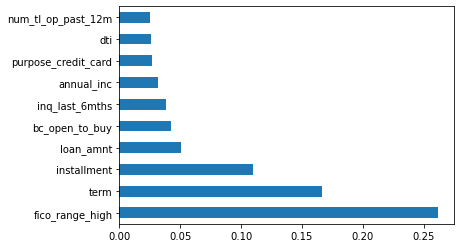

In [52]:
# the top 3 importances are the same as the decision tree
importances = model_rf.named_steps['randomforestregressor'].feature_importances_
features = model_rf.named_steps['onehotencoder'].get_feature_names()
feat_imp_rf = pd.Series(importances, index = features,
                       name = 'forest').abs().sort_values(ascending=False)
feat_imp_rf.head(10).plot(kind = 'barh')

# Boost Model
After testing out decision trees, random forests, boosted random forests, linear regression, and ridge regression, I found that the boosted model gave the lowest MAE and highest R^2 by a significant amount. Given this information, I decided to retrain every hyperparameter instead of assuming that overlapping parameters with other models like max_depth would have the same optimized value. 

In [96]:
# finding the optimal depth
depths = range(1, 20, 3)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
times = []

for depth in depths:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = depth))
    model.fit(X_train, y_train)

    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, times)), index = depths,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
1,2.022567,2.411168,0.506516,0.409007,6.229483
4,1.067171,1.462983,0.851477,0.775270,13.775368
7,0.559976,0.981228,0.958987,0.888616,24.352070
10,0.248948,0.922667,0.991527,0.896002,36.619136
13,0.063389,1.106082,0.999310,0.849355,49.131865
16,0.008349,1.224174,0.999985,0.813134,68.569854
19,0.000465,1.286523,1.000000,0.792358,86.724962


In [98]:
# still finding the optimal depth
depths = range(7, 13)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
times = []

for depth in depths:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = depth))

    model.fit(X_train, y_train)

    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, times)), index = depths,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])
# optimal depth is 9

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
7,0.559976,0.981228,0.958987,0.888616,22.302084
8,0.451831,0.936901,0.973493,0.897158,24.917931
9,0.336773,0.906595,0.985041,0.901681,31.290033
10,0.248948,0.922667,0.991527,0.896002,38.799618
11,0.172464,0.971304,0.995641,0.882165,40.825115
12,0.102199,0.985658,0.998345,0.881312,42.636395


In [99]:
# seeing how number of trees affects the model accuracy
estimators = [10] + [i for i in range(50, 300, 50)]
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
times = []

for estimator in estimators:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = estimator))

    model.fit(X_train, y_train)

    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, times)), index = estimators,
            columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 'Time'])
# 100 trees should be enough for optimizing hyperparameters, but use >200 for final model

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Time
10,1.458921,2.008019,0.718010,0.554908,6.007543
50,0.550692,1.073716,0.959439,0.865710,17.525789
100,0.336773,0.906595,0.985041,0.901681,32.649476
150,0.251377,0.861896,0.991494,0.910202,42.637807
200,0.200457,0.846407,0.994434,0.913051,54.431116
250,0.167735,0.841513,0.995969,0.913980,67.055414


In [100]:
# optimizing learning rate
learns = np.arange(0.01, 0.31, 0.05)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for learn in learns:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = learn))
    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = learns,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0.01,4.305632,4.873540,-0.921013,-0.995827,27.518515,29.380582
0.06,0.876257,1.379132,0.895031,0.784209,27.018967,28.907143
0.11,0.600575,1.120328,0.950245,0.852466,27.263737,29.134317
0.16,0.471246,1.005573,0.969751,0.879152,28.410104,30.141910
0.21,0.398929,0.949165,0.978735,0.892096,27.585426,29.463331
0.26,0.348024,0.893254,0.984035,0.902871,27.454771,29.316017


In [101]:
# need to expand learning rate parameter as accuracy kept increasing when learning rate hit 0.26
learns = np.arange(0.25, 0.51, 0.05)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for learn in learns:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = learn))
    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = learns,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0.25,0.374583,0.930133,0.981489,0.894100,27.072686,29.032215
0.30,0.336773,0.906595,0.985041,0.901681,29.615869,31.473083
0.35,0.325494,0.909625,0.986098,0.900672,27.444335,29.330502
0.40,0.335998,0.972642,0.985106,0.889159,26.720082,28.597790
0.45,0.328752,0.993242,0.985602,0.884518,27.156677,29.134295
0.50,0.324245,0.989111,0.985841,0.886558,28.117626,30.031494


In [102]:
# finding the true optimal learning rate
learns = np.arange(0.25, 0.35, 0.01)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for learn in learns:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = learn))
    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = learns,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0.25,0.374583,0.930133,0.981489,0.894100,28.336491,30.295004
0.26,0.348024,0.893254,0.984035,0.902871,28.561859,30.672797
0.27,0.360092,0.926709,0.982878,0.897102,28.271320,30.018318
0.28,0.351093,0.928276,0.983790,0.897119,26.917110,28.807216
0.29,0.344965,0.899407,0.984345,0.902267,27.685126,29.574629
0.30,0.336773,0.906595,0.985041,0.901681,26.960374,28.797447
0.31,0.326774,0.875840,0.985994,0.906885,27.769066,29.674996
0.32,0.329934,0.913480,0.985770,0.899803,27.565171,29.466691
0.33,0.351560,0.944354,0.983843,0.893561,27.175205,29.062419
0.34,0.331155,0.923316,0.985633,0.897106,27.457212,29.271358


In [103]:
# optimizing colsample_by tree hyperparameter, i.e. the subsample ratio for the columns when constructing
# the dataset for each tree
samples = np.arange(0.01, 1.00, 0.05)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for sample in samples:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = sample))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = samples,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0.01,2.265132,2.658796,0.405386,0.316841,3.407428,5.271665
0.06,1.730661,2.401781,0.630588,0.409034,5.026938,6.974753
0.11,1.563487,2.359201,0.692600,0.422647,5.689579,7.521530
0.16,1.478895,2.300724,0.722904,0.452204,6.607101,8.415193
0.21,1.376448,2.178777,0.759138,0.506195,7.703148,9.546548
0.26,1.341305,2.136572,0.769855,0.524740,8.333301,10.158824
0.31,1.110421,1.842890,0.839383,0.636588,9.379836,11.208366
0.36,1.034855,1.755981,0.860039,0.669203,10.413425,12.166705
0.41,1.006738,1.736587,0.867954,0.678911,11.303019,13.112994
0.46,0.864011,1.512336,0.902516,0.750600,11.705318,13.553090


In [143]:
# optimizing colsample_bylevel hyperparameter, i.e. the subsample ratio of the levels in each column
# when constructing each tree
samples = np.arange(0.01, 1.00, 0.05)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for sample in samples:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bylevel = sample))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = samples,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0.01,1.798353,2.429155,0.602226,0.400073,4.169355,6.021555
0.06,1.280633,2.322733,0.788227,0.448029,6.009362,7.882564
0.11,1.004720,2.069119,0.867691,0.557191,7.178469,9.024422
0.16,0.798174,1.814976,0.915653,0.652846,8.451295,10.258226
0.21,0.643834,1.564899,0.944326,0.733532,10.331754,12.192414
0.26,0.549895,1.404284,0.960203,0.784755,10.826890,12.612990
0.31,0.492136,1.280645,0.968289,0.814784,12.176496,14.042352
0.36,0.472485,1.264556,0.970903,0.820409,13.426852,15.244076
0.41,0.451787,1.185316,0.973174,0.840025,14.882225,16.617881
0.46,0.445414,1.174575,0.974025,0.842993,14.654241,16.416245


In [144]:
# optimizing colsample_bynode hyperparameter, i.e. the subsample ratio for each column when splitting
# a branch to make two new branches
samples = np.arange(0.01, 1.00, 0.05)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for sample in samples:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bynode = sample))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = samples,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0.01,1.798353,2.429155,0.602226,0.400073,4.202132,6.048055
0.06,1.280633,2.322733,0.788227,0.448029,6.181880,7.956294
0.11,1.004720,2.069119,0.867691,0.557191,6.791096,8.551435
0.16,0.798174,1.814976,0.915653,0.652846,8.129776,9.874844
0.21,0.643834,1.564899,0.944326,0.733532,9.412923,11.159865
0.26,0.549895,1.404284,0.960203,0.784755,11.257515,12.999838
0.31,0.492136,1.280645,0.968289,0.814784,11.694899,13.346529
0.36,0.472485,1.264556,0.970903,0.820409,12.938853,14.670997
0.41,0.451787,1.185316,0.973174,0.840025,14.623046,16.353415
0.46,0.445414,1.174575,0.974025,0.842993,15.383314,17.120264


In [107]:
# optimizing subsamples
subsamples = np.arange(0.01, 1.00, 0.05)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for sample in subsamples:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        subsample = sample))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = subsamples,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])
# we find that the best subsample value is the default value of 1

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0.01,4.413629,5.056001,-1.516213,-1.517837,10.295430,12.254829
0.06,1.415935,1.981269,0.738513,0.589954,11.379794,13.175313
0.11,0.989876,1.509975,0.873296,0.755453,13.080247,15.124846
0.16,0.790955,1.260727,0.918798,0.824278,14.655134,16.568756
0.21,0.724512,1.234590,0.932528,0.835016,15.820757,17.699851
0.26,0.642981,1.174714,0.946760,0.847054,16.901674,18.648818
0.31,0.581012,1.103267,0.956601,0.864621,18.181415,20.054232
0.36,0.525506,1.053003,0.964514,0.873908,19.954895,21.827754
0.41,0.488436,1.004780,0.969156,0.883887,20.794802,22.701168
0.46,0.477752,1.014751,0.970545,0.881267,22.304943,24.073319


In [108]:
# learning if a different boosting method would provide greater accuracy
boosters = ['gbtree', 'gblinear', 'dart']
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for boost in boosters:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        booster = boost))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = boosters,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

[01:11:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
gbtree,0.344965,0.899407,0.984345,0.902267,27.401877,29.275304
gblinear,1.970157,2.330319,0.529298,0.430439,2.876022,4.479491
dart,0.344965,0.899407,0.984345,0.902267,36.064976,38.148283


In [109]:
# optimizing alphas hyperparameter
alphas = range(0, 100, 5)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for alpha in alphas:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        reg_alpha = alpha))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = alphas,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0,0.344965,0.899407,0.984345,0.902267,27.506483,29.377646
5,0.391629,0.947911,0.979508,0.891173,26.916559,28.807611
10,0.439008,0.958825,0.974060,0.889524,27.413523,29.276994
15,0.454317,0.952485,0.971973,0.890390,27.345217,29.263388
20,0.472256,0.954751,0.969423,0.888598,26.879322,28.780426
25,0.492763,0.982929,0.966583,0.880468,26.758655,28.575058
30,0.508679,0.989497,0.964250,0.879750,26.708717,28.586421
35,0.523687,1.003239,0.962044,0.877804,26.462917,28.352404
40,0.522452,0.989624,0.961625,0.878296,26.629544,28.411969
45,0.545746,1.006524,0.957863,0.874862,26.396922,28.277545


In [113]:
# finish optimizing alphas hyperparameter
alphas = range(0, 5)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for alpha in alphas:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        reg_alpha = alpha))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_tune_train, model.predict(X_tune_train)))
    val_acc_boost.append(mean_absolute_error(y_tune_val, model.predict(X_tune_val)))
    train_r2_boost.append(model.score(X_tune_train, y_tune_train))
    val_r2_boost.append(model.score(X_tune_val, y_tune_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = alphas,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0,0.336003,0.823631,0.984873,0.906840,25.307738,25.522128
1,0.356787,0.829935,0.982614,0.905933,24.938883,25.153915
2,0.358501,0.811367,0.982295,0.909464,26.223801,26.459113
3,0.372988,0.820176,0.980786,0.906642,25.276711,25.498571
4,0.389040,0.833858,0.978819,0.904995,24.922245,25.157767


In [114]:
# optimizing lambda hyperparameter
lambdas = range(1, 6)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for l in lambdas:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        reg_lambda = l))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = lambdas,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])


,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
1,0.344965,0.899407,0.984345,0.902267,26.907414,28.600229
2,0.344977,0.912185,0.984208,0.898698,1987.020911,1989.366159
3,0.339320,0.884291,0.984564,0.904754,26.078574,27.823195
4,0.362562,0.926158,0.982281,0.895772,26.777786,28.631919
5,0.363661,0.928849,0.982134,0.894289,27.687171,29.601385


In [115]:
# optimizing gamma hyperparameter
gammas = range(0, 6)
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for g in gammas:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        gamma = g))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = gammas,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])


,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
0,0.344965,0.899407,0.984345,0.902267,26.758340,28.515100
1,0.351917,0.914928,0.983926,0.899822,25.123686,26.877084
2,0.373214,0.905837,0.982175,0.901593,24.862436,26.648125
3,0.398663,0.913498,0.979627,0.899555,24.928960,26.685407
4,0.412089,0.895746,0.978274,0.902462,24.941093,26.703442
5,0.434087,0.923174,0.975846,0.898701,25.998106,27.843100


In [145]:
# should we choose median instead of mean for SimpleImputer?
strats = ['mean', 'median']
train_acc_boost = []
val_acc_boost = []
train_r2_boost = []
val_r2_boost = []
train_times = []
score_times = []

for strat in strats:
    start = time.time()
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = strat),
                         XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        reg_alpha = 0,
                                        reg_lambda = 1,
                                        gamma = 0))

    model.fit(X_train, y_train)

    train_times.append(time.time() - start)
    train_acc_boost.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_boost.append(mean_absolute_error(y_val, model.predict(X_val)))
    train_r2_boost.append(model.score(X_train, y_train))
    val_r2_boost.append(model.score(X_val, y_val))
    score_times.append(time.time() - start)

pd.DataFrame(list(zip(train_acc_boost, val_acc_boost, train_r2_boost, val_r2_boost, train_times, score_times)), 
             index = strats,
             columns = ['Training Accuracy', 'Validation Accuracy', 'Training R^2', 'Validation R^2', 
                        'Train Time', 'Score Time'])
# mean works best, as expected - but median works surprisingly well

,Training Accuracy,Validation Accuracy,Training R^2,Validation R^2,Train Time,Score Time
mean,0.344965,0.899407,0.984345,0.902267,26.481550,28.215710
median,0.334195,0.900944,0.985359,0.901148,26.680176,28.502702


In [116]:
# time to build our final model with all our hyperparameters
model_boost = make_pipeline(OneHotEncoder(use_cat_names = True),
                           StandardScaler(),
                           SimpleImputer(strategy='mean'),
                           XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 9,
                                        n_estimators = 100,
                                        learning_rate = 0.29,
                                        colsample_bytree = 1,
                                        reg_alpha = 0,
                                        reg_lambda = 1,
                                        gamma = 0))

In [117]:
%%time
model_boost.fit(X_train, y_train)

CPU times: user 2min 51s, sys: 2.35 s, total: 2min 53s
Wall time: 27.2 s


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['home_ownership', 'verification_status',
                                     'purpose'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.29,
                              max_delta_step=0, max_depth=9, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
     

In [118]:
%%time
print('Training MAE:', mean_absolute_error(y_train, model_boost.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_boost.predict(X_val)))
print('Validation R2:', model_boost.score(X_val, y_val))

Training MAE: 0.34496464560571966
Validation MAE: 0.8994065691179319
Validation R2: 0.9022665324154702
CPU times: user 3.83 s, sys: 335 ms, total: 4.17 s
Wall time: 1.07 s


In [132]:
# check cross validation score
cross_vals = cross_val_score(model_boost, X, y)
print(np.mean(cross_vals))
# it's actually higher than our previous R^2

0.9123584023146762


<AxesSubplot:>

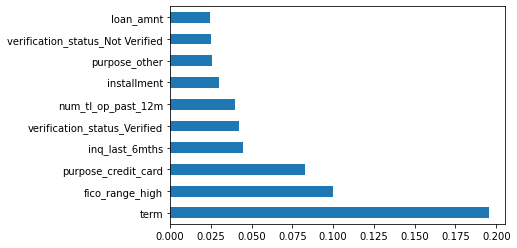

In [146]:
importances = model_boost.named_steps['xgbregressor'].feature_importances_
features = model_boost.named_steps['onehotencoder'].get_feature_names()
feat_imp_boost = pd.Series(importances, index = features,
                          name = 'boost').abs().sort_values(ascending=False)
feat_imp_boost.head(10).plot(kind = 'barh')

# Ridge Regression

In [147]:
alphas = np.arange(0, 6)
train_acc_ridge = []
val_acc_ridge = []
for a in alphas:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = a))
    model.fit(X_train, y_train)
    train_acc_ridge.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_ridge.append(mean_absolute_error(y_val, model.predict(X_val)))
    
pd.DataFrame(list(zip(train_acc_ridge, val_acc_ridge)), index = alphas, 
             columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
0,1.821935,2.150289
1,1.822044,2.149810
2,1.822115,2.149895
3,1.822186,2.149980
4,1.822258,2.150067
5,1.822330,2.150154


In [148]:
model_ridge = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = 1))

In [149]:
model_ridge.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train, model_ridge.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_ridge.predict(X_val)))
print('Validation R2:', model_ridge.score(X_val,y_val))

Training MAE: 1.8220438129808365
Validation MAE: 2.1498096703868845
Validation R2: 0.5212556280653425


<AxesSubplot:>

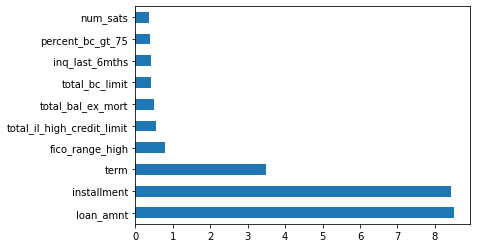

In [150]:
importances = model_ridge.named_steps['ridge'].coef_
features = model_ridge.named_steps['onehotencoder'].get_feature_names()
feat_imp_ridge = pd.Series(importances, index = features,
                          name = 'ridge').abs().sort_values(ascending=False)
feat_imp_ridge.head(10).plot(kind = 'barh')

# Linear Regression

In [151]:
model_linear = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            LinearRegression())

In [152]:
model_linear.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train, model_linear.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_linear.predict(X_val)))
print('Validation R2:', model_linear.score(X_val,y_val))

Training MAE: 1.821964672670216
Validation MAE: 2.1497278134142492
Validation R2: 0.5212789361051063


<AxesSubplot:>

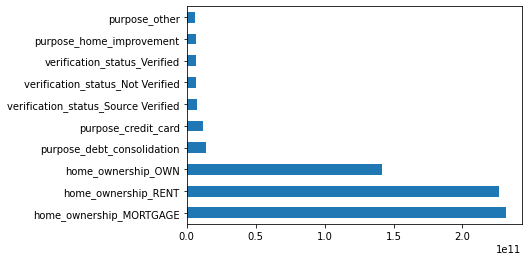

In [153]:
importances = model_linear.named_steps['linearregression'].coef_
features = model_linear.named_steps['onehotencoder'].get_feature_names()
feat_imp_linear = pd.Series(importances, index = features,
                           name = 'linear').abs().sort_values(ascending=False)
feat_imp_linear.head(10).plot(kind = 'barh')